c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28376
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 3548
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3548
    })
})
Label index: 0


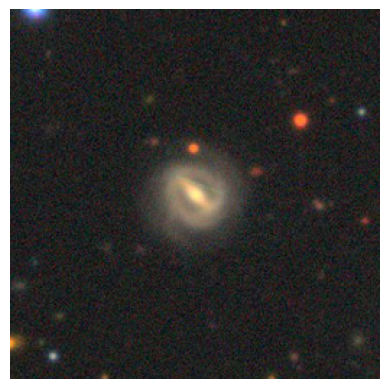

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt


dataset = load_dataset("Xanadu00/autotrain-data-galaxy_classification")
print(dataset)

sample = dataset["train"][0]

image = sample["image"]
label = sample["label"]

print("Label index:", label)


plt.imshow(image)
plt.axis("off")
plt.show()


In [3]:
from torchvision import transforms


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
transformed= train_transform(image)
print(transformed.shape)




torch.Size([3, 224, 224])


In [2]:

import torch
from torch.utils.data import Dataset, DataLoader

class GalaxyDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"]
        label = sample["label"]

        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = GalaxyDataset(dataset["train"], transform=train_transform)
val_dataset   = GalaxyDataset(dataset["validation"], transform=val_transform)


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)



NameError: name 'dataset' is not defined

In [6]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

label_names = dataset["train"].features["label"].names


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model = models.resnet18(pretrained=True)


num_classes = len(label_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using device: cpu
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\asus/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 11.9MB/s]


In [11]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [8]:
num_epochs = 3

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


Epoch [1/3] Train Loss: 0.7186, Train Acc: 0.7579 | Val Loss: 0.6765, Val Acc: 0.7734


Epoch [2/3] Train Loss: 0.2538, Train Acc: 0.9175 | Val Loss: 0.7325, Val Acc: 0.7892


Epoch [3/3] Train Loss: 0.0873, Train Acc: 0.9761 | Val Loss: 0.8550, Val Acc: 0.7883


In [9]:
torch.save(model.state_dict(), "galaxy_resnet18_epoch3.pth")


In [ ]:
import os
print("galaxy_resnet18_epoch3.pth" in os.listdir())
#The model was trained for three epochs. Although the final epoch achieved higher training accuracy, the best validation performance was observed at epoch 2. This indicates the onset of overfitting beyond epoch 2, and hence early stopping at epoch 2 would be optimal.



True


In [14]:
print("Preds:", len(all_preds))
print("Labels:", len(all_labels))


Preds: 768
Labels: 768


In [15]:
import torch
torch.cuda.empty_cache()


In [16]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")

plt.title("Confusion Matrix – Galaxy Morphology Classification")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.close()


In [4]:


from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


num_classes = 10
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


train_dataset_aug = GalaxyDataset(dataset["train"], transform=train_transform_aug)

train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)


model_aug = models.resnet18(pretrained=True)
model_aug.fc = nn.Linear(model_aug.fc.in_features, num_classes)
model_aug = model_aug.to(device)


optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


num_epochs = 2

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model_aug, train_loader_aug, optimizer_aug, criterion
    )
    val_loss, val_acc = evaluate(
        model_aug, val_loader, criterion
    )

    print(
        f"[Aug] Epoch {epoch+1}/{num_epochs} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )


NameError: name 'GalaxyDataset' is not defined